## 1- Importing libraries

also doing some logistics

In [25]:
!pip install Sastrawi

In [26]:
#Load all the needed libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import json
from pprint import pprint
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
plt.style.use('seaborn-ticks')

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2- Loading Train/test data

In [0]:
path = '/content/drive/My Drive/GitHub/nsdc_beginner/Data'

#path = './Data'
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftest = pd.read_csv(os.path.join(path, 'test.csv'))


In [30]:
with open(os.path.join(path,'categories.json')) as f:
    categories = json.load(f)

pprint(categories)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
            

## 3- Feature Engineering

### 3.1 Divide the training data into Big categories containers (Beauty/Fashion/Mobile)

In [0]:
# 1. add a new col that contins the big category (beauty, fashion, mobile)

newCol = dftrain.image_path.apply(lambda x : x.split('_')[0])
dftrain['mainCat'] = newCol
# dftrain.head()

Check for unique values

In [32]:
set(dftrain['mainCat'])

{'beauty', 'fashion', 'mobile'}

### 3.2 Display the total number of samples under each category

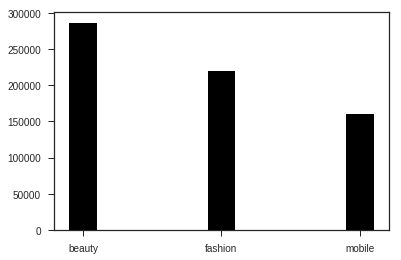

In [33]:
Beautydf= dftrain[dftrain['mainCat'] == 'beauty']
Fashiondf= dftrain[dftrain['mainCat'] == 'fashion']
Mobiledf= dftrain[dftrain['mainCat'] == 'mobile']

plt.bar(['beauty', 'fashion', 'mobile'],[Beautydf.shape[0],Fashiondf.shape[0],Mobiledf.shape[0]],width=0.2, color='black');

#### 3.2.1 EDA

In [34]:
Fashiondf.head()

,itemid,title,Category,image_path,mainCat
286583,2282553,retro floral dress,17,fashion_image/78d17fdb159bba51a4250dc3d583245e,fashion
286584,13822218,dress floral sifon,18,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,fashion
286585,33555935,korean white chiffon collar dress,18,fashion_image/6dbe2e7cba5ddbb750d2144d8f248f11,fashion
286586,65755120,women s trendy apricot o neck solid chiffon bl...,19,fashion_image/dc9b21429604148fc0342d12694f3294,fashion
286587,65857438,big sale baju gamis pesta india aysilla pancar...,20,fashion_image/6c25c578dd8edce742a805f891f1a51f,fashion


In [35]:
Fashiondf.shape

(219702, 5)

### 3.3 Randomize the train-dataset

To avoid bias in the training dataset, it is a good practice

In [36]:
Beautydf.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            286573, 286574, 286575, 286576, 286577, 286578, 286579, 286580,
            286581, 286582],
           dtype='int64', length=286583)

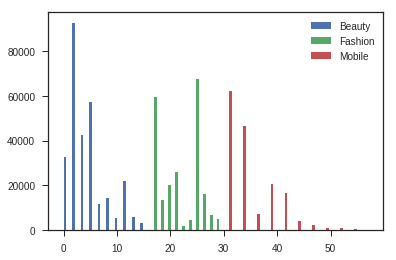

In [37]:
# randomize datasets

Beautydf = Beautydf.reindex(np.random.permutation(Beautydf.index))
Fashiondf = Fashiondf.reindex(np.random.permutation(Fashiondf.index))
Mobiledf = Mobiledf.reindex(np.random.permutation(Mobiledf.index))

# Beautydf.Category.hist(width = 0.5)
# Fashiondf.Category.hist(width = 0.5)
# Mobiledf.Category.hist(width = 0.5)

fig, catAx = plt.subplots(1, 1)

catAx.hist(Beautydf.Category, label='Beauty', width=0.5)
catAx.hist(Fashiondf.Category, label='Fashion', width=0.5)
catAx.hist(Mobiledf.Category , label='Mobile', width=0.5)

catAx.legend()
plt.show()

### 3.4 Remove any number with more than 3 digits in the dataset

For example : `02854323232` which could be an id or something


In [38]:
# Remove any number in the dataset with more than or equal to 3 digits. 

Beautydf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Fashiondf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Mobiledf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)

600120              promo cuci gudang oppo f7 pro 6gb 128gb
521512     promo akhir tahun beli 2 gratis big special s...
586974    exacoat garskin iphone x skin original titaniu...
567114                               handphone lava iris 88
599181                    promo cuci gudang samsung j7 pro 
526794    tempered glass full cover 4d iphone 6 6s plus ...
515796    promo toko cuci gudang oppo f5 ram 4gb rom 32g...
507594                            iphone 7 128gb blackmatte
589519    sony xperia z5 dual love mei powerful case cas...
585805           promo vivo v7 black beli 2 gratis 1 wa ...
561481                          ipad mini 4 128gb wifi only
527368                       xiaomi mi5 pro 128gb  original
645160    beli 1 gratis promo cuci gudang apple ipad pro...
541422                  samsung galaxy star s5282 4gb black
592282                                    vivo y91 ram 2 16
603121    promo oppo f7 dp 10 saja lewat kredit plus rea...
548264      iphone 7 plus seken fulset m

In [39]:
Fashiondf['Category'].value_counts()

18    56598
25    33922
26    33845
20    19978
27    16199
22    15225
19    13493
21    10483
28     6493
24     4251
29     3338
17     2765
23     1671
30     1441
Name: Category, dtype: int64

#### 3.5.1 Check the phrase of the length

#### 3.8 Remove the top common words across all categories which may not be helping with the classification

## 4- Cross Validation

### 4.1 Split the training dataset into train/test

In [0]:
B_X_train = Beautydf.title
B_y_train = Beautydf.Category

F_X_train = Fashiondf.title
F_y_train = Fashiondf.Category

M_X_train = Mobiledf.title
M_y_train = Mobiledf.Category

In [0]:
def tokenize_data(vect, X_train, X_test):
    ''' Tokenize the training and test set'''
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # print the number of features that were generated
    #print('Features: ', X_train_dtm.shape[1])
    
    return X_train_dtm, X_test_dtm

In [0]:
skfolds = StratifiedKFold(n_splits=5, random_state=42)
for train_index, test_index in skfolds.split(M_X_train, M_y_train):
    y_train_folds = M_y_train.iloc[train_index]


In [0]:
from time import monotonic
from datetime import timedelta
import sklearn.metrics as metrics
import sys

def trainCV(X_train, y_train, vect, folds = 5, random_state=42, 
            clf=SGDClassifier(random_state=42, max_iter=5000, tol=1e-3, 
                              loss='hinge', verbose=1)):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)

    skfolds = StratifiedKFold(n_splits=folds, random_state=random_state)

    cv_start_time = monotonic()
    
    scores = []
    features = []
    for train_index, test_index in skfolds.split(X_train, y_train):
        start_time = monotonic()
        
        clone_clf = clone(clf)
        #X_train_folds = X_train[train_index]
        y_train_folds = y_train.iloc[train_index]
        #X_test_fold = X_train[test_index]
        y_test_fold = y_train.iloc[test_index]
        
        X_train_folds,X_test_fold = tokenize_data(vect, 
                                                  X_train.iloc[train_index], 
                                                  X_train.iloc[test_index])
        features.append(X_train_folds.shape[1])
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        scores.append(n_correct / len(y_pred))
        
        end_time = monotonic()
        print("Training time per fold: {}".format(timedelta(seconds=end_time - start_time)))

        
    print ("Features: {}".format(features))
    print("Features variance: %0.2f (+/- %0.2f)" % (np.mean(features), 
                                                    np.std(features) * 2))
    print ("Scores: {}".format(scores))
    print("Accuracy: %0.5f (+/- %0.5f)" % (np.mean(scores), 
                                           np.std(scores) * 2))
    
    cv_end_time = monotonic()
    print("Total Training time: {}".format(timedelta(seconds=cv_end_time - cv_start_time)))
    
    return clone_clf, scores, features

### 4.2 Defining Stop words

In [44]:
# Adding Bahaya Stop words 

factory = StopWordRemoverFactory()
id_stopwords = factory.get_stop_words()
en_stopwords  = list(stopwords.words('english'))
stopwords = id_stopwords + en_stopwords
stopwords[1:20]

#F_stopWords = ['dress', 'lengan', 'wanita', 'women', 'untuk', 'neck', 'model', 'top', 'panjang']
#F_stopWords2 = ['lengan', 'untuk', 'neck', 'model', 'top', 'panjang']
#F_stopWords3 = ['untuk', 'neck', 'model', 'top', 'panjang']
#B_stopWords = ['lip', 'cream', 'promo', 'bb', 'original', 'cushion', 'ml', 'natural', 'nature', 'murah']

['untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena']

### 4.3 Model Training for Beauty

#### 4.3.1 Optiming for nrange

Optimal hyperparam is at nrange 1,8 with Accuracy: 0.78536 (+/- 0.00335)

With slight improvement seen using One vs Rest with Accuracy: 0.78557 (+/- 0.00376)

And with stop words Accuracy: 0.78435 (+/- 0.00327)

* Features: [2060519, 2059314, 2055361, 2059141, 2059118]
* Features variance: 2058690.60 (+/- 3487.51)
* Scores: [0.7866127034523664, 0.787446355674959, 0.7855958965053998, 0.784320910106086, 0.7857579088799316]
* Accuracy: 0.78595 (+/- 0.00210)
* Total Training time: 0:04:07.240765

#### 4.4.2 Training for Optimal Model for Mobile

Optimal hyperparam for Mobile is with nrange of 1,5 with Accuracy: 0.82828 (+/- 0.00265)

Using One vs Rest is seeing slight improvement with Accuracy: 0.82856 (+/- 0.00143).

And with stop words: Accuracy: 0.82006 (+/- 0.00239).

* Features: [1030842, 1029869, 1029107, 1030184, 1027609]
* Features variance: 1029522.20 (+/- 2215.01)
* Scores: [0.8285375814446488, 0.8311040438998535, 0.8259784812100421, 0.8314981752394024, 0.8282692787621662]
* Accuracy: 0.82908 (+/- 0.00405)
* Total Training time: 0:02:20.155520

### 4.5 Model Training for Fashion

#### 4.5.1 Optiming for the nrange for Fashion

Optimal for Fashion is Ngram range of 1,14 with Accuracy: 0.64612 (+/- 0.00261)

And using One vs Rest with Accuracy: 0.64587 (+/- 0.00192).

With stop words with Accuracy: 0.64569 (+/- 0.00502).

Using RandomizedGridSearch
* Features: [2574193, 2573700, 2572438, 2571429, 2575672]
* Features variance: 2573486.40 (+/- 2919.42)
* Scores: [0.6499567651208301, 0.6513210295155087, 0.6532929771061854, 0.6549754187909687, 0.6576988733356094]
* Accuracy: 0.65345 (+/- 0.00545)
* Total Training time: 0:04:32.68714

#### 4.5.2 Find Optimal Model for Fashion

Best count vectorizer param appears to be at min df =1, max df = 0.6 and max features at 100,000.

#### 4.5.5 Testing stemming next

### 1.0 Fashion Optimization

In [0]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
F_vect = CountVectorizer(ngram_range=(1,6), analyzer='word')
Fs_vect = CountVectorizer(ngram_range=(1,6), stop_words=stopwords, analyzer='word')


In [0]:
def randomSearch(X, y, vect):
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                               test_size=0.33, random_state=42)
  
  X_train_dtm, X_test_dtm = tokenize_data(vect, X_train, X_test)
  
  params = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100],
    #"max_iter" : [1000, 5000]
  }

  n_iter_search = 10
  model = PassiveAggressiveClassifier(tol=1e-3, loss='hinge', random_state=42)
  clf = RandomizedSearchCV(model, 
                           param_distributions=params, 
                           cv=5,
                     scoring='accuracy',
                     error_score='raise',
                     verbose =2,
                     n_jobs=-1,
                     n_iter=n_iter_search,
                    #loss="hinge",
                    #penalty="l2"
                    )
  
  start = time()

  clf.fit(X_train_dtm, y_train)

  print("RandomizedSearchCV took %.2f seconds for %d candidates"
        " parameter settings." % ((time() - start), n_iter_search))
  report(clf.cv_results_)
  
  return clf

def printBestScore(clf):
  print("Best score {}".format(clf.best_score_))
  print("Best estimator {}".format(clf.best_estimator_))

In [48]:
F_clf = randomSearch(F_X_train, F_y_train, Fs_vect)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.8min finished


RandomizedSearchCV took 1332.90 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.638 (std: 0.003)
Parameters: {'C': 0.001}

Model with rank: 2
Mean validation score: 0.621 (std: 0.004)
Parameters: {'C': 0.01}

Model with rank: 3
Mean validation score: 0.609 (std: 0.004)
Parameters: {'C': 0.1}



In [49]:
printBestScore(F_clf)

Best score 0.6375747282608696
Best estimator PassiveAggressiveClassifier(C=0.001, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


Running using the best model

In [0]:
F_bestModel = F_clf.best_estimator_

In [51]:
Fo_sgd, Fo_scores, Fo_features = trainCV(F_X_train, F_y_train, vect=Fs_vect, 
                                         clf=F_bestModel)

Training time per fold: 0:02:21.723305
Training time per fold: 0:02:21.451670
Training time per fold: 0:02:21.328239
Training time per fold: 0:01:42.885582
Training time per fold: 0:01:44.008763
Features: [2569788, 2570780, 2574570, 2576112, 2573836]
Features variance: 2573017.20 (+/- 4740.65)
Scores: [0.6464752195876757, 0.6543476776733496, 0.6554776751171999, 0.6491032410779315, 0.6500739729145328]
Accuracy: 0.65110 (+/- 0.00670)
Total Training time: 0:10:31.576618


### 2.0 For Beauty

In [0]:
B_vect = CountVectorizer(ngram_range=(1,8))
Bs_vect = CountVectorizer(ngram_range=(1,8), stop_words=stopwords)

In [53]:
B_clf = randomSearch(B_X_train, B_y_train, Bs_vect)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.4min finished


RandomizedSearchCV took 600.77 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.775 (std: 0.002)
Parameters: {'C': 0.001}

Model with rank: 2
Mean validation score: 0.771 (std: 0.001)
Parameters: {'C': 0.01}

Model with rank: 3
Mean validation score: 0.748 (std: 0.003)
Parameters: {'C': 0.1}



In [54]:
printBestScore(B_clf)

Best score 0.775470027602729
Best estimator PassiveAggressiveClassifier(C=0.001, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
B_bestModel = B_clf.best_estimator_

In [56]:
Bo_sgd, Bo_scores, Bo_features = trainCV(B_X_train, B_y_train, vect=Bs_vect, 
                                         clf=B_bestModel)

Training time per fold: 0:01:13.548267
Training time per fold: 0:01:15.441467
Training time per fold: 0:01:14.542281
Training time per fold: 0:01:11.879905
Training time per fold: 0:01:14.683370
Features: [2058398, 2055614, 2060434, 2060323, 2058074]
Features variance: 2058568.60 (+/- 3528.29)
Scores: [0.7836819426757148, 0.7838177314120233, 0.7848107891201563, 0.7794179229480737, 0.7813083459840514]
Accuracy: 0.78261 (+/- 0.00393)
Total Training time: 0:06:10.282179


### 3.0 For Mobile

In [0]:
Ms_vect = CountVectorizer(ngram_range=(1,5), stop_words=stopwords)
M_vect = CountVectorizer(ngram_range=(1,5))

In [58]:
M_clf = randomSearch(M_X_train, M_y_train, Ms_vect)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.8min finished


RandomizedSearchCV took 430.36 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.821 (std: 0.002)
Parameters: {'C': 0.01}

Model with rank: 2
Mean validation score: 0.819 (std: 0.001)
Parameters: {'C': 0.001}

Model with rank: 3
Mean validation score: 0.803 (std: 0.002)
Parameters: {'C': 0.1}



In [59]:
printBestScore(M_clf)

Best score 0.8207054486552908
Best estimator PassiveAggressiveClassifier(C=0.01, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
M_bestModel = M_clf.best_estimator_

In [61]:
Mo_sgd, Mo_scores, Mo_features = trainCV(M_X_train, M_y_train, vect=Ms_vect, 
                                         clf=M_bestModel)

Training time per fold: 0:00:45.069448
Training time per fold: 0:00:50.820213
Training time per fold: 0:00:44.080251
Training time per fold: 0:00:39.037037
Training time per fold: 0:00:38.729012
Features: [1030619, 1030049, 1028061, 1029365, 1029694]
Features variance: 1029557.60 (+/- 1711.97)
Scores: [0.827976431711195, 0.8282667664390609, 0.8230469359114299, 0.8316853301724945, 0.8270526578487647]
Accuracy: 0.82761 (+/- 0.00554)
Total Training time: 0:03:37.870725


### 4.6 Checking the scores

#### 4.6.1 Summary:
---
 

1.   **Beauty Category**:    `ngram_range(1, 8) OVR`
---
2.   **Fashion Category**:    `ngram_range(1, 14) OVR`
---
3.   **Mobile Category**:    `ngram_range(1,5) OVR`
---

In [62]:
total_scores = Bo_scores+ Fo_scores+ Mo_scores
print("OvO with stopwords Accuracy: %0.5f (+/- %0.5f)" % (np.mean(total_scores), 
                                       np.std(total_scores) * 2))


OvO with stopwords Accuracy: 0.75377 (+/- 0.14988)


#### 4.5.1 Result comparison:
* OvO with stopwords Accuracy: 0.75610 (+/- 0.15001)
* OvO without stopwords Accuracy: 0.75598 (+/- 0.15262)
* OvR with stopwords Accuracy: 0.75615 (+/- 0.14967)

Your submission scored 0.76247, which is not an improvement of your best score. Keep trying!


## 5- Modelling

1. Divide the test dataset into 3 Categories
2. Remove numbers more than 3 Digits from the test dataset.
3. Train + Predict.


### 5.1 Divide the test dataset into 3 Categories

In [0]:
#add category col
newTestCol = dftest.image_path.apply(lambda x: x.split('_')[0])
dftest['newCat'] = newTestCol

In [64]:
dftest.tail()

,itemid,title,image_path,newCat
172397,1781957365,nokia 5.1 plus ram 3gb 32gb garansi resmi 1 ta...,mobile_image/3dbd99b9d999d326d8ae57f7ad1f1b3e.jpg,mobile
172398,1839851276,big promo add whatshap 0821 9127 5399 iphone 7...,mobile_image/6d45e5c7e36ac897f58a9f72ff4bf0b8.jpg,mobile
172399,955369303,datang lagi sharp r1 ram 3gb 32gb gratis silic...,mobile_image/08f68bb1cc3f381364776ac5cfd9e45e.jpg,mobile
172400,1638035772,sony xperia z5 premium au ram 3gb rom 32gb sec...,mobile_image/1d0610ea0f43d75ecc3ff951f6c647d4.jpg,mobile
172401,1498091427,xiaomi mi 8 ram 6 128gb black,mobile_image/6649fa043a7b2eebda6ed904c966a14b.jpg,mobile


<BarContainer object of 3 artists>

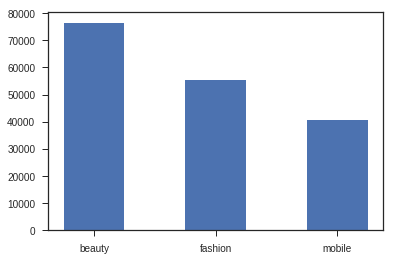

In [65]:
MobileTest = dftest[dftest['newCat'] == 'mobile']
BeautyTest = dftest[dftest['newCat'] == 'beauty']
FashionTest = dftest[dftest['newCat'] == 'fashion']

fig, axt = plt.subplots(1,1)
axt.bar(['beauty', 'fashion', 'mobile'], [len(BeautyTest), len(FashionTest), len(MobileTest)], width=0.5)


### 5.3 Prediction Dataset

In [0]:
B_X_test = BeautyTest.title
F_X_test = FashionTest.title
M_X_test = MobileTest.title

### 5.4 Prediction Function

In [0]:
def modelPredict(X_train, y_train, X_test, vect, 
                 clf=SGDClassifier(random_state=42,max_iter=5000, 
                                            tol=1e-3,loss='hinge')):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)
    
    X_train_dtm,X_test_dtm = tokenize_data(vect, X_train, X_test)
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    return y_pred

In [0]:
B_y_pred = modelPredict(B_X_train, B_y_train, B_X_test, Bs_vect, clf=Bo_sgd)

In [0]:
F_y_pred = modelPredict(F_X_train, F_y_train, F_X_test, Fs_vect, clf=Fo_sgd)

In [0]:
M_y_pred = modelPredict(M_X_train, M_y_train, M_X_test, Ms_vect, clf=Mo_sgd)

### 5.5 Run Prediction

In [71]:
BeautyTest['Category'] = B_y_pred
FashionTest['Category'] = F_y_pred
MobileTest['Category'] = M_y_pred


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

## 6- Result

In [0]:
resDf = BeautyTest.append(FashionTest).append(MobileTest)


In [0]:
FinalResult = pd.concat([resDf['itemid'], resDf['Category']], axis=1, 
                        keys=['itemid', 'Category'])
FinalResult.to_csv(path + '{}_NDSC_Res.csv'.format(datetime.datetime.today().strftime('%Y%m%d%H%M')
                                                  ), index=False)